In [1]:
import pandas as pd
pd.__version__

'0.20.3'

In [2]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['font.size'] = 16

### String Constants

In [3]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '1029'
outdir_prefix = 'graphs/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
UNIFORM = "Uniform Sampling"

bb_prefix = "bbSoftmax"
bb_infix = "BB0N"

better_infix = "PreferBetterActionsEqualMeans"
worse_infix = "PreferWorseActionsEqualMeans"

ng_prefix = "ngSoftmax"
ng_infix = "NG0N"
var_infix = "Var"

prefer_infix_lst = (better_infix, worse_infix)
preference_label = ("Higher-earlier", "Higher-later")

# (Optimal, softmax 0.0 - 0.5)
colors = ('#fed976','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84')

### Simulation Settings

In [4]:
effectSizeB = 0.3
effectSizeN = 0.5
softmaxRange = np.arange(0.0, 0.6, 0.1)

variancesN = {'394':'5.0', '64':'2.0', '26':'1.25'}
nsN=(394, 64, 26)

variancesB = {better_infix:"", worse_infix:"1.25"}
nsB=(785, 88, 32)

mean_names_lst = []
std_names_lst = []
for i in range(len(softmaxRange)):
    mean_names_lst.append("Softmax "+str(softmaxRange[i]))
    std_names_lst.append("softmax "+str(softmaxRange[i])+" std")
mean_names_lst   

['Softmax 0.0',
 'Softmax 0.1',
 'Softmax 0.2',
 'Softmax 0.3',
 'Softmax 0.4',
 'Softmax 0.5']

# Average Reward Gain per Step

In [5]:
def scale_normal_rewards(x, arm):
    return (x + (0.5 - arm))

In [6]:
import ast
def get_same_arm(softmax, reward_type):
    preference = prefer_infix_lst[0]
    if reward_type == BINARY:
        effect_size = effectSizeB
        v = str(variancesB[preference])
        summary = open(bb_prefix+str(softmax)+preference+v+bb_infix+str(nsB[0])+summary_suffix)
    elif reward_type == NORMAL:
        effect_size = effectSizeN
        v = str(variancesN['394'])
        summary = open(ng_prefix+str(softmax)+preference+v+ng_infix+str(nsN[0])+var_infix+v+summary_suffix)

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return ast.literal_eval(arms)[:2][0]

In [7]:
def get_avg_col_per_num_steps_dfs(preference_infix, ns, reward_type, col):
    df_lst = []
    if reward_type == BINARY:
        effect_size = str(effectSizeB)
        prefix = bb_prefix
        infix = bb_infix
        v_lst = variancesB
    elif reward_type == NORMAL:
        effect_size = str(effectSizeN)
        prefix = ng_prefix
        infix = ng_infix
        v_lst = variancesN
    
    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        if reward_type == BINARY:
            v = v_lst[preference_infix]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+df_suffix)
        elif reward_type == NORMAL:
            v = v_lst[str(ns)]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+var_infix+v+df_suffix)
        df_lst.append(df)

        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [8]:
get_avg_col_per_num_steps_dfs(worse_infix, nsN[2], NORMAL, 'total_reward')

Softmax 0.0  Softmax 0.1  Softmax 0.2  Softmax 0.3  Softmax 0.4  \
num_steps                                                                    
26           -0.234335     0.191483    -0.449850     0.191822     0.311652   
52           -0.188808     0.248572     0.327435    -0.368903    -0.081378   
104           0.248266     0.350707    -0.171495     0.575587    -0.941233   
208           0.173891    -0.804064    -0.015090    -0.725810     0.438164   

           Softmax 0.5  softmax 0.0 std  softmax 0.1 std  softmax 0.2 std  \
num_steps                                                                   
26            0.104169         6.475016         6.289091         6.239965   
52            0.041084         8.506260         8.994969         8.436503   
104          -0.026179        12.283844        12.127323        13.695422   
208           1.449565        17.867394        18.365263        17.440408   

           softmax 0.3 std  softmax 0.4 std  softmax 0.5 std  
num_steps                                                     
26                6.585862         6.383799         6.503585  
52                8.994916         9.087173         8.891040  
104              12.662904        12.509204        12.650225  
208              18.185557        17.521635        19.074208

In [9]:
def get_avg_col_per_step_dfs(preference_infix, ns, reward_type, col):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(preference_infix, ns, reward_type, col)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg                
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(get_same_arm(softmaxRange[0], NORMAL),))

    return avg_total_rewards

In [10]:
get_avg_col_per_step_dfs(worse_infix, nsN[1], NORMAL, 'total_reward')

Softmax 0.0  Softmax 0.1  Softmax 0.2  Softmax 0.3  Softmax 0.4  \
num_steps                                                                    
64            0.495567     0.497815     0.512321     0.497603     0.509309   
128           0.504962     0.500617     0.497811     0.506383     0.498173   
256           0.509182     0.501516     0.503641     0.504504     0.506288   
512           0.501499     0.501003     0.503711     0.502297     0.500018   

           Softmax 0.5  softmax 0.0 std  softmax 0.1 std  softmax 0.2 std  \
num_steps                                                                   
64            0.493895         0.249152         0.243158         0.265021   
128           0.505039         0.173696         0.177355         0.175546   
256           0.501325         0.128628         0.130806         0.122591   
512           0.499166         0.082917         0.089110         0.094312   

           softmax 0.3 std  softmax 0.4 std  softmax 0.5 std  
num_steps                                                     
64                0.245977         0.243549         0.255036  
128               0.174708         0.178426         0.181995  
256               0.130828         0.132976         0.118337  
512               0.087165         0.088508         0.085711

# Average Reward Gain at Step

In [14]:
def plot_avg_reward_gain_at_m_single(reward_type, legend_anchor=(1.4, 0.8)):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
        ns = nsB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        ns = nsN
    for i in range(len(prefer_infix_lst)):
        for s in ns:
            df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], s, reward_type, "total_reward").iloc[1:2]
            if reward_type == BINARY:
                df_m["Optimal Reward"] = get_same_arm(softmaxRange[0], reward_type)
            else:
                arm = get_same_arm(softmaxRange[0], reward_type)
                df_m["Optimal Reward"] = scale_normal_rewards(arm, arm)

            df_m["or_std"] = pd.Series()

            df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    xticks = []

    if reward_type == BINARY:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n steps="+str(y), ns))+\
                           list(map(lambda y:preference_label[1]+"\n steps="+str(y), ns)))
    elif reward_type == NORMAL:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n var="+variancesN[str(y)], ns))+\
                           list(map(lambda y:preference_label[1]+"\n var="+variancesN[str(y)], ns)))
        
    ax.set_ylabel("Rewards")
    
    ax.legend(bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

In [15]:
ax = plot_avg_reward_gain_at_m_single(BINARY)

### Normal Rewards

In [16]:
ax = plot_avg_reward_gain_at_m_single(NORMAL)

### Combine Plots

In [17]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55)):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
        ns = nsB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
        ns = nsN
    for i in range(len(prefer_infix_lst)):
        for s in ns:
            df_m = get_avg_col_per_step_dfs(prefer_infix_lst[i], s, reward_type, "total_reward").iloc[1:2]
            if reward_type == BINARY:
                df_m["Optimal Reward"] = get_same_arm(softmaxRange[0], reward_type)
            else:
                arm = get_same_arm(softmaxRange[0], reward_type)
                df_m["Optimal Reward"] = scale_normal_rewards(arm, arm)


            df_m["or_std"] = pd.Series()

            df = pd.concat([df, df_m])

    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors)

    ax.set_xlabel("")
    if reward_type == BINARY:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n steps="+str(y), ns))+\
                           list(map(lambda y:preference_label[1]+"\n steps="+str(y), ns)))
    elif reward_type == NORMAL:
        ax.set_xticklabels(list(map(lambda y:preference_label[0]+"\n var="+variancesN[str(y)], ns))+\
                           list(map(lambda y:preference_label[1]+"\n var="+variancesN[str(y)], ns)))
    ax.set_ylabel(ylabel)
    
    if hasLegend:
        ax.legend(bbox_to_anchor=legend_anchor)
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Binary Reward")
    elif reward_type == NORMAL:
        ax.set_title("Scaled, Normal Reward")
    return ax

In [51]:
figure = plt.figure(figsize = (16, 4))

# Bar for Binary Reward 
ax = figure.add_subplot(1, 2, 1)
plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(-0.1, 0.8))

# Bar for Normal Reward 
ax = figure.add_subplot(1, 2, 2)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False)

# Set super title for all subgraphs
plt.subplots_adjust(top=0.85)
figure.savefig(outdir_prefix+date_prefix+'AvgRewardGainPerStep.pdf', bbox_inches='tight')

# Power

In [19]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()

    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [27]:
def plot_power_bar(df, x_col, y_col, ax, setLegend, title, legend_anchor=(0.5, 1.7), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

In [21]:
binary_power = []
binary_power_all_steps = []
effect_size = str(effectSizeB)
prefix = bb_prefix
infix = bb_infix
ns = str(nsB[0])

for i in range(len(prefer_infix_lst)):
    df_lst = []
    columns = list(mean_names_lst)
    preference_infix = prefer_infix_lst[i]
    v = variancesB[preference_infix]

    for i in range(len(softmaxRange)):
        softmax = softmaxRange[i]
        df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
    binary_power.append(power_df)
    binary_power_all_steps.append(power_all_steps)

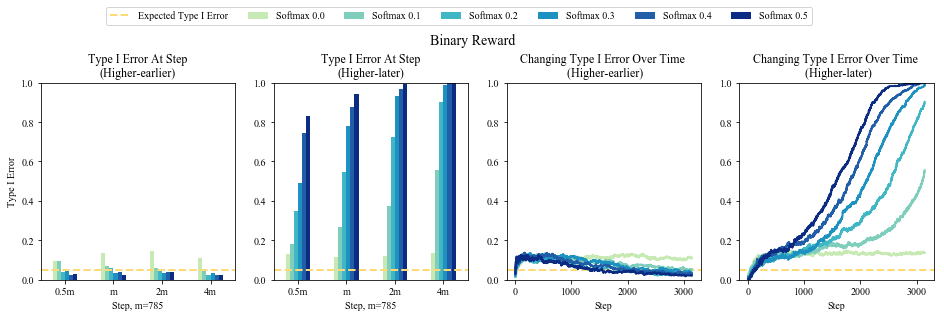

In [49]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
# Bar graph for power at step m
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)

    avg_power_binary = binary_power[i]
    plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                   "Type I Error At Step\n("+preference_label[i]+")",\
                   legend_anchor=(4, 1.41), ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")
    setLegend = False
    
# Line graph for power per step
for i in range(len(prefer_infix_lst)):
    ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
    ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
    j = 1
    all_steps = binary_power_all_steps[i]
    for p in all_steps:
        x = range(10, len(p)+10)
        ax.plot(x, p, lw=2, color=colors[j])
        j+=1
    ax.set_xlabel('Step')
    # set visualization range to 0-1
    ax.set_ylim(0.0, 1.0)
    
    plt.title("Changing Type I Error Over Time \n ("+preference_label[i]+")")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredTypeIErrorPerStepBinary.pdf', bbox_inches='tight')

### Normal Reward

In [24]:
normal_power_vars = []
normal_power_all_steps_vars = []
for ns in nsN:            
    v = variancesN[str(ns)]
    normal_power = []
    normal_power_all_steps = []
    effect_size = str(effectSizeN)
    prefix = ng_prefix
    infix = ng_infix

    for i in range(len(prefer_infix_lst)):
        df_lst = []
        columns = list(mean_names_lst)
        preference_infix = prefer_infix_lst[i]

        for i in range(len(softmaxRange)):
            softmax = softmaxRange[i]
            df = pd.read_pickle(prefix+str(softmax)+preference_infix+v+infix+str(ns)+var_infix+v+byTrial_suffix)
            df_lst.append(df)

        power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
        normal_power.append(power_df)
        normal_power_all_steps.append(power_all_steps)
    
    normal_power_vars.append(normal_power)
    normal_power_all_steps_vars.append(normal_power_all_steps)

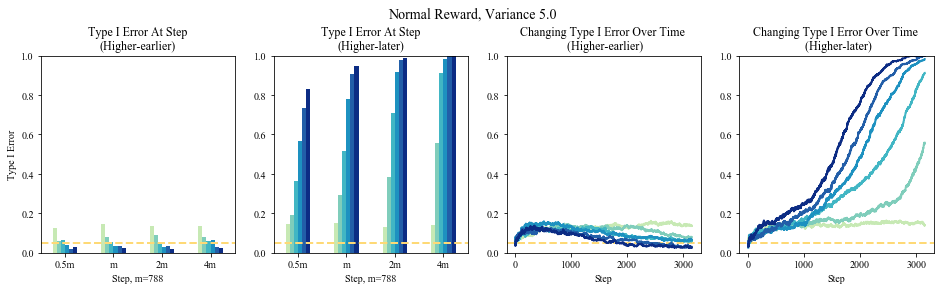

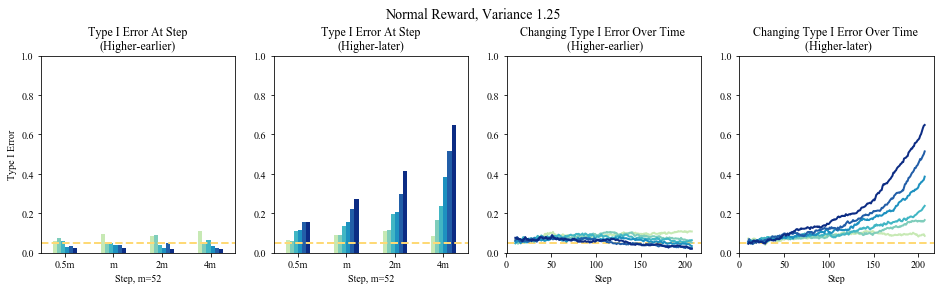

In [50]:
for foo in range(len(nsN)):
    normal_power = normal_power_vars[foo]
    normal_power_all_steps = normal_power_all_steps_vars[foo]
    
    figure = plt.figure(figsize = (16, 4))
    setLegend = False
    # Bar graph for power at step m
    for i in range(len(prefer_infix_lst)):
        ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 1)
        if (i == 0):
            ax.set_ylabel("Type I Error")
        avg_power_normal = normal_power[i]
        plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), ax, setLegend, \
                       "Type I Error At Step\n("+preference_label[i]+")", \
                       ylabel="Type I Error", hline_value=0.05, hline_label="Expected Type I Error")

    # Line graph for power per step
    for i in range(len(prefer_infix_lst)):
        ax = figure.add_subplot(1, len(prefer_infix_lst) + 2, i + 3)
        ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
        j = 1
        all_steps = normal_power_all_steps[i]
        for p in all_steps:
            x = range(10, len(p)+10)
            ax.plot(x, p, lw=2, color=colors[j])
            j+=1
        ax.set_xlabel('Step')
        # set visualization range to 0-1
        ax.set_ylim(0.0, 1.0)
    
        plt.title("Changing Type I Error Over Time \n ("+preference_label[i]+")")

    figure.suptitle("Normal Reward, Variance "+variancesN[str(nsN[foo])],  fontsize=14)
    plt.subplots_adjust(top=0.81)
    figure.savefig(outdir_prefix+date_prefix+'Var'+variancesN[str(nsN[foo])]+'MeasuredTypeIErrorPerStepNormal.pdf', bbox_inches='tight')